In [1]:
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
%matplotlib notebook
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
import astropy
from astropy import cosmology
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
from astropy.coordinates import SkyOffsetFrame
import astropy.units as u
cosmo = FlatLambdaCDM(H0=75. * u.km / u.s / u.Mpc, Om0=0.31)
c = 299792.458
from ellipsoid import*

In [2]:
hdu = fits.open('CF4gp_new_64-z008_velocity.fits')
hdu_d = fits.open('CF4gp_new_64-z008_delta.fits')
hdu_e = fits.open('CF4gp_new_64-z008_velocity_cube_error.fits')

In [3]:
np.shape(hdu)

(1,)

In [5]:
t = 52.*hdu[0].data
t_e = 52.*hdu_e[0].data
np.shape(t_e)

(64, 64, 64)

In [6]:
print (np.mean(t_e), np.max(t_e), np.min(t_e))

141.22563713766425 408.261737732514 14.937477391966485


In [7]:
t_d = hdu_d[0].data

In [9]:
np.shape(t)

(3, 64, 64, 64)

In [10]:
np.shape(t_d)

(64, 64, 64)

In [11]:
print (t[:,63,10,10],t_d[63,10,10])

[121.200165 200.14859   42.35306 ] 0.03911024


In [46]:
Lania = pd.read_csv("laniakea.csv")
Lania

,X,Y,Z
0,-7.8125,0.0000,-62.5000
1,0.0000,0.0000,-62.5000
2,-7.8125,7.8125,-62.5000
3,0.0000,7.8125,-62.5000
4,-7.8125,0.0000,-54.6875
...,...,...,...
3453,-54.6875,-54.6875,187.5000
3454,-46.8750,-54.6875,187.5000
3455,-70.3125,-46.8750,187.5000
3456,-62.5000,-46.8750,187.5000


In [47]:
u = Lania["X"]
v = Lania["Y"]
w = Lania["Z"]

In [48]:
ii = np.rint(np.round(32. + ((64./1000.)*u),0)).astype(int)
jj = np.rint(np.round(32. + ((64./1000.)*v),0)).astype(int)
kk = np.rint(np.round(32. + ((64./1000.)*w),0)).astype(int)

In [49]:
max(kk)

44

In [50]:
lania_vv = t[:,kk,jj,ii]

In [51]:
print (np.mean(lania_vv[0]))

-55.175247


In [52]:
lania_cf4 = pd.DataFrame(np.column_stack((u,v,w,lania_vv[2],lania_vv[1],lania_vv[0])),columns=["SGX","SGY","SGZ","vx","vy","vz"])
lania_cf4

,SGX,SGY,SGZ,vx,vy,vz
0,-7.8125,0.0000,-62.5000,198.023834,173.473755,-55.513783
1,0.0000,0.0000,-62.5000,198.023834,173.473755,-55.513783
2,-7.8125,7.8125,-62.5000,198.023834,173.473755,-55.513783
3,0.0000,7.8125,-62.5000,198.023834,173.473755,-55.513783
4,-7.8125,0.0000,-54.6875,198.023834,173.473755,-55.513783
...,...,...,...,...,...,...
3453,-54.6875,-54.6875,187.5000,-228.536102,25.211275,222.808090
3454,-46.8750,-54.6875,187.5000,-229.369263,-9.903706,213.526794
3455,-70.3125,-46.8750,187.5000,-274.572876,17.027435,212.022064
3456,-62.5000,-46.8750,187.5000,-274.572876,17.027435,212.022064


In [53]:
lania_cf4.to_csv("new_laniakea_cf4_velocities.csv", index = False, header = True)

In [92]:
eansa = ls_ellipsoid(lania_cf4.SGX,lania_cf4.SGY,lania_cf4.SGZ)

In [93]:
print("coefficients:"  , eansa)
center,axes,inve = polyToParams3D(eansa,True)   #get ellipsoid 3D parameters
print("center:"        , center)
print("axes:"          , axes)
print("rotationMatrix:", inve)

coefficients: [ 4.82417033e-05  1.38095935e-04  6.17102299e-05  8.54568989e-05
  1.09583880e-04  1.83168827e-04 -6.35535843e-03 -2.80484122e-03
  2.70214835e-03 -1.00000000e+00]

polynomial
 [ 4.82417033e-05  1.38095935e-04  6.17102299e-05  8.54568989e-05
  1.09583880e-04  1.83168827e-04 -6.35535843e-03 -2.80484122e-03
  2.70214835e-03 -1.00000000e+00]

Algebraic form of polynomial
 [[ 4.82417033e-05  4.27284495e-05  5.47919401e-05 -3.17767922e-03]
 [ 4.27284495e-05  1.38095935e-04  9.15844135e-05 -1.40242061e-03]
 [ 5.47919401e-05  9.15844135e-05  6.17102299e-05  1.35107417e-03]
 [-3.17767922e-03 -1.40242061e-03  1.35107417e-03 -1.00000000e+00]]

Center at: [ -94.64259766 -112.43540449  229.00429909]

Algebraic form translated to center
 [[ 4.82417033e-05  4.27284495e-05  5.47919401e-05  0.00000000e+00]
 [ 4.27284495e-05  1.38095935e-04  9.15844135e-05 -1.73472348e-18]
 [ 5.47919401e-05  9.15844135e-05  6.17102299e-05 -2.16840434e-19]
 [ 0.00000000e+00 -1.73472348e-18 -2.16840434e-19 

In [94]:
vec01 = polyToParams3D(eansa,"true")


polynomial
 [ 4.82417033e-05  1.38095935e-04  6.17102299e-05  8.54568989e-05
  1.09583880e-04  1.83168827e-04 -6.35535843e-03 -2.80484122e-03
  2.70214835e-03 -1.00000000e+00]

Algebraic form of polynomial
 [[ 4.82417033e-05  4.27284495e-05  5.47919401e-05 -3.17767922e-03]
 [ 4.27284495e-05  1.38095935e-04  9.15844135e-05 -1.40242061e-03]
 [ 5.47919401e-05  9.15844135e-05  6.17102299e-05  1.35107417e-03]
 [-3.17767922e-03 -1.40242061e-03  1.35107417e-03 -1.00000000e+00]]

Center at: [ -94.64259766 -112.43540449  229.00429909]

Algebraic form translated to center
 [[ 4.82417033e-05  4.27284495e-05  5.47919401e-05  0.00000000e+00]
 [ 4.27284495e-05  1.38095935e-04  9.15844135e-05 -1.73472348e-18]
 [ 5.47919401e-05  9.15844135e-05  6.17102299e-05 -2.16840434e-19]
 [ 0.00000000e+00 -1.73472348e-18 -2.16840434e-19 -2.32172661e-01]] 

normed 
 [[1.         0.88571602 1.13577955]
 [0.88571602 2.86258416 1.898449  ]
 [1.13577955 1.898449   1.27918845]]

Axes are
 [ 32.18329121  80.9167151  14

In [95]:
xin = lania_cf4.SGX
yin = lania_cf4.SGY
zin = lania_cf4.SGZ

In [96]:
check01 = printAns3D(center,axes,inve,xin,yin,zin,"True")


Center at    -94.6426, -112.4354,  229.0043
Axes gains    32.1833,   80.9167,  141.6714 
Rotation Matrix
  -0.35458,  -0.75826,  -0.54709
  -0.80100,   0.54818,  -0.24063
  -0.48237,  -0.35290,   0.80174

Transformation Matrix
 [[0.01347806 0.00412927 0.00567984]
 [0.00412927 0.02245797 0.00926266]
 [0.00567984 0.00926266 0.01455297]]

Average Radius      1.8347 (truth is 1.0)
Stdev of Radius     0.5082
 


<IPython.core.display.Javascript object>


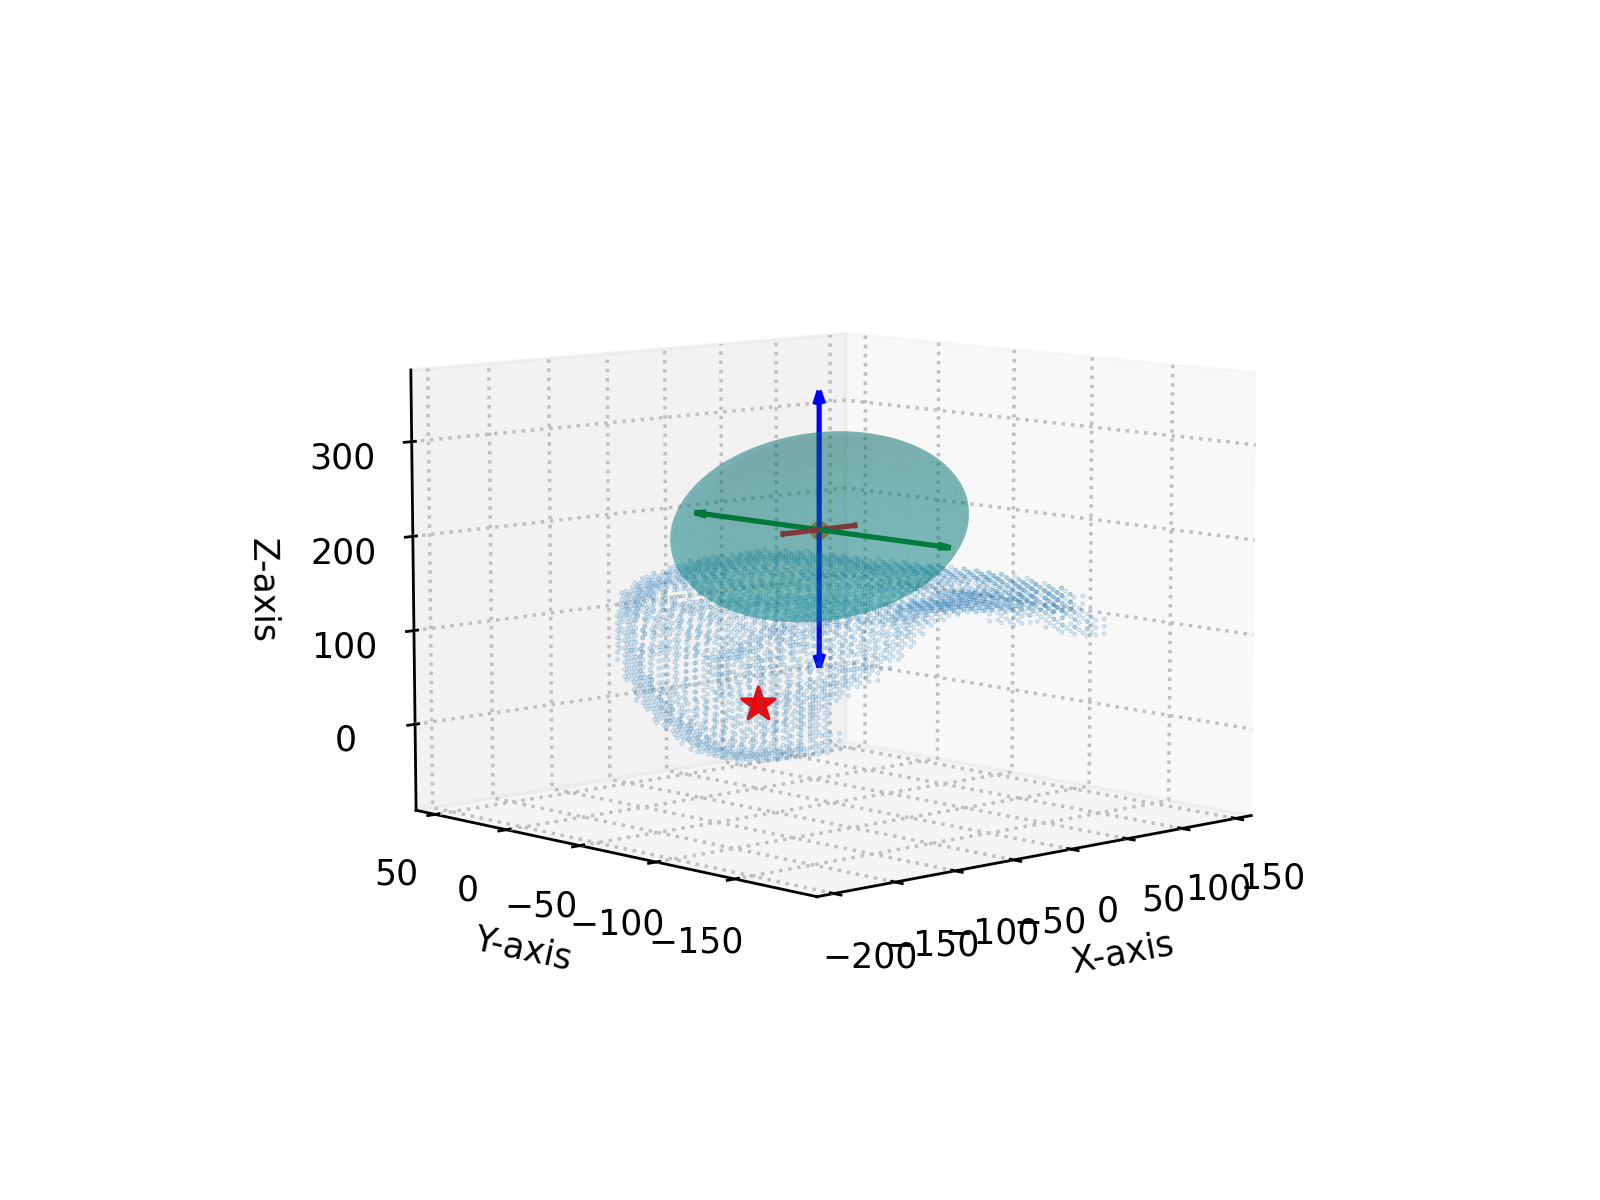

In [97]:
# Center of the ellipsoid
center = center

# Axes of the ellipsoid (semi-major axis length)
axes = axes

# Rotation matrix
R = inve

# Generate points on the ellipsoid
uu = np.linspace(0, 2 * np.pi, 100)
vv = np.linspace(0, np.pi, 100)
x = axes[0] * np.outer(np.cos(uu), np.sin(vv))
y = axes[1] * np.outer(np.sin(uu), np.sin(vv))
z = axes[2] * np.outer(np.ones_like(uu), np.cos(vv))

# Transform the points using the rotation matrix
for i in range(len(x)):
    for j in range(len(x)):
        [x[i,j], y[i,j], z[i,j]] = np.dot([x[i,j], y[i,j], z[i,j]], R) + center

# Plot the ellipsoid
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lania_cf4.SGX,lania_cf4.SGY,lania_cf4.SGZ,s=0.1,alpha=0.3)
ax.plot_surface(x, y, z, color='c', alpha=0.3)
ax.scatter(center[0],center[1],center[2])
ax.scatter(0,0,0,color="red",marker='*',s=100)
ax.quiver(center[0], center[1], center[2], axes[0]*-1.0, 0, 0, color='r', length=1.0, arrow_length_ratio=0.1)
ax.quiver(center[0], center[1], center[2], 0, axes[1]*-1.0, 0, color='g', length=1.0, arrow_length_ratio=0.1)
ax.quiver(center[0], center[1], center[2], 0, 0, axes[2]*-1.0, color='b', length=1.0, arrow_length_ratio=0.1)
ax.quiver(center[0], center[1], center[2], axes[0], 0, 0, color='r', length=1.0, arrow_length_ratio=0.1)
ax.quiver(center[0], center[1], center[2], 0, axes[1], 0, color='g', length=1.0, arrow_length_ratio=0.1)
ax.quiver(center[0], center[1], center[2], 0, 0, axes[2], color='b', length=1.0, arrow_length_ratio=0.1)
#ax.grid(False)
#ax.axis('off') # Remove the axes
ax.xaxis._axinfo["grid"].update({"linewidth":1, "color" : "0.75","linestyle" :":"})
ax.yaxis._axinfo["grid"].update({"linewidth":1, "color" : "0.75","linestyle" :":"})
ax.zaxis._axinfo["grid"].update({"linewidth":1, "color" : "0.75","linestyle" :":"})
#ax.grid(b=True, color='0.05',linestyle=':')
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.savefig('new_ellipsoid.png', dpi=300)
plt.show()